# Tutorial: One Machine against Infinite Bus (OMIB)

This tutorial will introduce you to the functionality of `LITS` for running Power System Simulations.
Note that this tutorial is for `LITS 0.3.0`. Future versions will have dedicated functions to find an equilibrium point using a Power Flow method without relying in a guess of the initial condition to run a non-linear solver.

This tutorial presents a simulation of a two-bus system, with an infinite bus (represented as a voltage source behind an impedance) at bus 1 and a classic machine on bus 2. The perturbation will be the trip of one of the two circuits (doubling its resistance and impedance) of the line that connects both buses.

This tutorial can be found on [LITS/Examples](https://github.com/Energy-MAC/LITS-Examples) repository.

## Step 1: Package Initialization

The first step consists in initialize all packages that will be used to run the simulation. All the necessary packages are listed. Please note that loading the packages may take some time.

In [2]:
using LITS
using PowerSystems
using Sundials
using Plots

`PowerSystems` is used to properly define the data structure, while `Sundials` is used to solve the problem defined in `LITS`.

## Step 2: Data creation

Next we need to define the different elements required to run a simulation. To run a simulation, it is required to define a `System` that requires the following components:

- Vector of `Bus` elements, that define all the buses in the network.
- Vector of `Branch` elements, that define all the branches elements (that connect two buses) in the network.
- Vector of `DynamicInjection` elements, that define all the devices connected to buses that can inject (or withdraw) current, while also defining differential equations to model its dynamics. These include generators and inverters.
- Vector of `PowerLoad` elements, that define all the loads connected to buses that can withdraw current, without defining any differential equation. Note that `LITS` will convert ConstantPower loads to RLC loads for transient simulations.
- Vector of `Source` elements, that define source components behind a reactance that can inject or withdraw current, without defining any differential equation.
- The base of power used to define per unit values, in MVA as a `Float64` value.
- The base frequency used in the system, in Hz as a `Float64` value.
- (Optional) Selecting which of the `Lines` (of the `Branch` vector) elements must be modeled of `DynamicLines` elements, that can be used to model lines with differential equations.

To start we will define the data structures for the network.

### Buses and Branches

As mentioned earlier, we require to create a `Vector` of `Bus` to define the buses in the network. Currently, some of the parameters are not used in `LITS`, but will be used once the initialization procedure is implemented (such as voltage limits or the requested bus voltage).

In [3]:
#Define the vector of buses
nodes_OMIB = [
    Bus(
        1, #number
        "Bus 1", #Name
        "REF", #BusType (REF, PV, PQ)
        0, #Angle in radians
        1.05, #Voltage in pu
        (min = 0.94, max = 1.06), #Voltage limits in pu
        69, #Base voltage in kV
    ),
    Bus(2, "Bus 2", "PV", 0, 1.0, (min = 0.94, max = 1.06), 69),
];

Note that two buses are defined in the vector `nodes_case1`. It is important that the bus numbers are ordered from ``1`` to ``n``, since that structure will be used to construct the vector of variables. Future versions of `LITS` will allow to relax this assumption. Similarly, to define the branches (that also has some parameters that are currently not used, such as the rate and angle limits):

In [4]:
#Define the vector of branches
branch_OMIB = [Line(
    "Line1", #name
    true, #available
    0.0, #active power flow initial condition (from-to)
    0.0, #reactive power flow initial condition (from-to)
    Arc(from = nodes_OMIB[1], to = nodes_OMIB[2]), #Connection between buses
    0.01, #resistance in pu
    0.05, #reactance in pu
    (from = 0.0, to = 0.0), #susceptance in pu
    18.046, #rate in MW
    1.04, #angle limits (-min and max)
)];

Since we are interested in creating a fault that trips one of the two circuits of the line, we will create an additional `Vector` of branches with doubled impedance:

In [5]:
#Define the vector of branches under the fault
branch_OMIB_fault = [Line(
    "Line1", #name
    true, #available
    0.0, #active power flow initial condition (from-to)
    0.0, #reactive power flow initial condition (from-to)
    Arc(from = nodes_OMIB[1], to = nodes_OMIB[2]), #Connection between buses
    0.02, #resistance in pu
    0.1, #reactance in pu
    (from = 0.0, to = 0.0), #susceptance in pu
    18.046, #rate in MW
    1.04, #angle limits (-min and max)
)];

Note that the resistance and reactance is doubled in comparison to the system without fault.

### Injection devices

Secondly, we will define devices that can inject/withdraw electric current directly without defining differential equations. In this case we include a load and the voltage source that model the infinite bus.

In [6]:
loads_OMIB = [PowerLoad(
    "LBus1", #name
    true, #availability
    nodes_OMIB[2], #bus
    PowerSystems.ConstantPower, #type
    0.3, #P
    0.01, #Q
    0.3, #P_max
    0.01, #Q_max
)]

inf_gen_OMIB = [Source(
    "InfBus", #name
    true, #availability
    nodes_OMIB[1], #bus
    1.05, #VR
    0.0, #VI
    0.000005, #Xth
)];

Note that loads are assumed as constant power for power flow purposes, but for dynamic simulations are converted to impedance loads assuming nominal voltage equals to 1 pu.

### Dynamic Injection devices

Third, we define the `Vector` of `DynamicInjection` elements. In this case, we require to define a generator located in bus 2. For that purpose, we need to define its machine, shaft, automatic voltage regulator (AVR), turbine governor (TG) and power system stabilizer (PSS):

In [7]:
### Machine ###
machine_OMIB = BaseMachine(
    0.0, #R
    0.2995, #Xd_p
    0.7087, #eq_p
    100.0,
)  #MVABase

######## Shaft Data #########

### Shaft for Case 1 ###
shaft_OMIB = SingleMass(
    3.148, #H
    2.0, #D
)

########  AVR Data #########
avr_OMIB = AVRFixed(0.0) #Vf not applicable in Classic Machines

######## TG Data #########
### No TG ###
tg_OMIB = TGFixed(1.0) #No TG: Efficiency = 1.0

######## PSS Data #########
### No PSS ###
pss_OMIB = PSSFixed(0.0) #No PSS without AVR

### Constructing the Generator ###
gen_OMIB = DynamicGenerator(
    1, #Number
    "OMIB_Gen", #name
    nodes_OMIB[2], #bus
    1.0, #ω_ref
    1.0, #V_ref
    0.5, #P_ref
    0.0, #Q_ref: Not used for standard machines (only for PQ gens)
    machine_OMIB, #machine
    shaft_OMIB, #shaft
    avr_OMIB, #avr
    tg_OMIB, #tg
    pss_OMIB, #pss
);

Note that a generator is defined by its 5 components, while also defining its reference for frequency, voltage and power. The reactive power reference must be defined but is not used for standard machines, since is only used for PQ generators, that will be implemented in future versions of `LITS`.

### Defining the Dynamic System

Finally, with all the components properly constructed we define the dynamic system:

In [8]:
#Create the system
sys = System(
      100.0, #Base MVA
      frequency = 60.0, #Nominal frequency in Hz
)

#Add the buses to the system
for bus in nodes_OMIB
    add_component!(sys, bus)
end

#Add the branches to the system
for br in branch_OMIB
    add_component!(sys, br)
end

#Add the loads to the system
for load in loads_OMIB
    add_component!(sys, load)
end

#Add the sources (infinite gens) to the system
for source in inf_gen_OMIB
    add_component!(sys, source)
end

#Add the generator
add_component!(sys, gen_OMIB)

┌ Warning: struct DynamicGenerator does not exist in validation configuration file, validation skipped
└ @ InfrastructureSystems /Users/rhenriquez/.julia/packages/InfrastructureSystems/wvWoQ/src/validation.jl:42


## Step 3: Build the simulation and initializing the problem

The next step is to create the simulation structure. This will create the indexing of our system that will be used to formulate the differential-algebraic system of equations. To do so, it is required to specify the perturbation that will occur in the system. `LITS` support two types of perturbations:
- Three Phase Fault
- Change in Reference Parameter

In here, he will use a Three Phase Fault, that is modeled by modifying the admittance matrix of the system. To do so we create a ThreePhaseFault perturbation as follows:

In [9]:
#Obtain the Ybus of the faulted system
Ybus_fault = Ybus(
    branch_OMIB_fault, #fault set of lines
    nodes_OMIB, #set of buses
)[:,:]

#Construct the perturbation
perturbation_Ybus = ThreePhaseFault(
    1.0, #change will occur at t = 1.0s
    Ybus_fault, #new Ybus
);

With this, we are ready to create our simulation structure. We will skip solving for initial conditions to discuss about indexing. To construct our simulation we use:

In [10]:
#Time span of our simulation
tspan = (0.0, 30.0)

#Define Simulation
sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
    initialize_simulation = false #keyword argument to not find initial conditions.
)

Simulation()


This will create the simulation structure that will be used to run the transient simulation and will modify the system to include the indexing. `LITS` will have the following structure for the vector of variables:

$$x = \left[\begin{array}{c} v_r \\ v_i \\ z \end{array}\right]$$

on which $v_r$ is the vector of real voltages of all buses, $v_i$ is the vector of imaginary voltages of all buses and $z$ is the rest of states defined by the dynamic devices. Then, the length of the vector of variables will $2n + \text{len}(z)$, where $n$ is the number of buses in the system. The indexing of the states can be found using:

In [11]:
ext = get_ext(sim.system) #Obtain ext information of the system
ext["global_index"] #Showcase the global indexing of z

Dict{String,Dict{Symbol,Int64}} with 1 entry:
  "OMIB_Gen" => Dict(:ω=>6,:δ=>5)

In this system, $\delta$ of the generator is state 5 and $\omega$ is state 6 (since the first 4 states are the bus voltages). In addition, ``ext["lits_counts"]`` has information on the total variables and total states (differential variables).

The next step consists in finding an initial condition for the states. In this case simply running       

In [12]:
#Define Simulation
sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
)

┌ Info: Initializing Simulation States
└ @ LITS /Users/rhenriquez/.julia/packages/LITS/uFVsj/src/base/simulation.jl:27


Simulation()


will correctly initialize the system. If no initial guess is provided, the system will use a flat start guess, assuming that all real voltages are equal to one, while imaginary voltages are equal to zero. Differential variables (states) will be guessed as zero too. The initial values can be obtained using ``sim.x0_init``.

In [13]:
# Initial condition obtained with a flat start
sim.x0_init 

6-element Array{Float64,1}:
 1.049994801403534   
 0.9998075882667568  
 8.993757618485317e-7
 0.01939184992634203 
 0.2323013344356654  
 1.0                 

However, for most systems if a bad initial guess is used, the non-linear solver may fail in correctly initializing the system. For such purposes, an initial guess can be provided to the simulation as follows:

In [14]:
#Initial guess
x0_guess = [
    1.0, #VR_1
    1.0, #VR_2
    0.0, #VI_1
    0.0, #VI_2
    0.2, #δ
    1.0, #ω
]
#Define Simulation
sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
    initial_guess = x0_guess, #initial guess
)

sim.x0_init

┌ Info: Initializing Simulation States
└ @ LITS /Users/rhenriquez/.julia/packages/LITS/uFVsj/src/base/simulation.jl:27


6-element Array{Float64,1}:
 1.049994801403533   
 0.9998075882692508  
 8.99375768572439e-7 
 0.019391849995778525
 0.23230133510717615 
 1.0                 

## Step 4: Run the Simulation

Finally, to run the simulation we simply use:

In [15]:
#Solve problem
run_simulation!(sim, #simulation structure
                IDA(), #Sundials DAE Solver
                dtmax=0.02); #Arguments: Maximum timestep allowed

In some cases, the dynamic time step used for the simulation may fail. In such case, the keyword argument `dtmax` can be used to limit the maximum time step allowed for the simulation.

## Step 5: Exploring the solution

After running the simulation, our simulation structure `sim` will have the solution. For that `sim.solution` can be used to explore the solution structure. In this case `sim.solution.t` returns the vector of time, while `sim.solution.u` return the array of states. In addition, `LITS` have two functions to obtain different states of the solution:

- ``get_state_series(sim, ("OMIB_Gen", :δ))``: can be used to obtain the solution as a tuple of time and the required state. In this case, we are obtaining the rotor angle `:δ` of the generator named `"OMIB_Gen"`.
- ``get_voltagemag_series(sim, 2)``: can be used to obtain the voltage magnitude as a tuple of time and voltage. In this case, we are obtaining the voltage magnitude at bus 2 (where the generator is located).

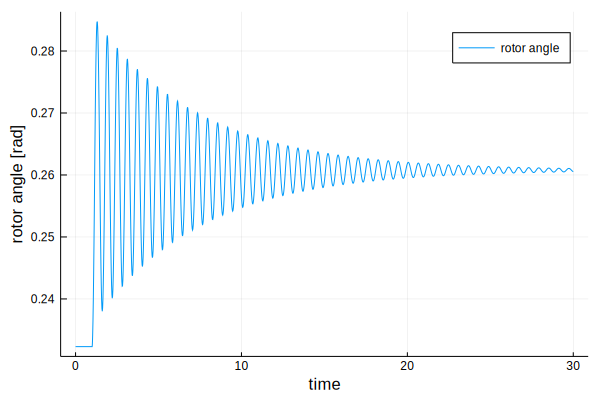

In [16]:
angle = get_state_series(sim, ("OMIB_Gen", :δ))
plot(angle, xlabel="time", ylabel="rotor angle [rad]", label="rotor angle")

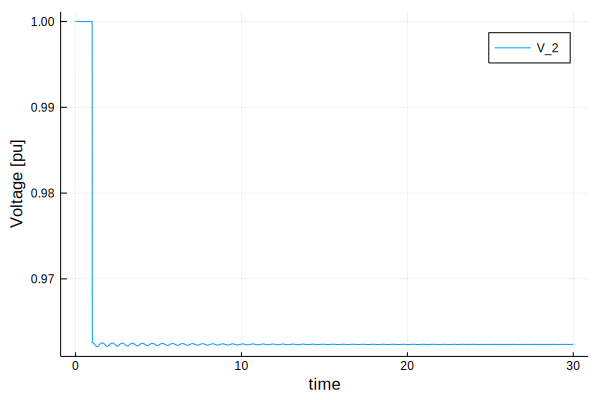

In [17]:
volt = get_voltagemag_series(sim, 2)
plot(volt, xlabel="time", ylabel="Voltage [pu]", label="V_2")

## Optional: Small Signal Analysis

`LITS 0.3.0` uses automatic differentiation to compute the reduced Jacobian of the system for the differential states. This can be used to analyze the eigenvalues of the linearized system.

In [18]:
small_sig = small_signal_analysis(sim)

The system is small signal stable


The `small_sig` result can report the reduced jacobian for $\delta$ and $\omega$, and can also be used to report the eigenvalues of the reduced linearized system.

In [19]:
small_sig.reduced_jacobian

2×2 Array{Float64,2}:
  0.0       376.991   
 -0.300708   -0.317662

In [20]:
small_sig.eigenvalues

2-element Array{Complex{Float64},1}:
 -0.15883100381194398 - 10.646085881059669im
 -0.15883100381194398 + 10.646085881059669im